# Sesión 7 
## Análisis de datos con python
### Jorge M. Orozco Thomas
<img src="img/Logo_uninorte.jpg" alt="Imagen" width="900" height="150">

---

Objetivos de esta sesión  
 
✔ Familiarizarse con las bases de datos del DANE.  
✔ Tener una estrategia de trabajo definida para comenzar el tratamiento de bases de datos según nuestras necesidades.  
✔ Generar archivos para un ambito de trabajo colaborativo.

---

# Precios Mayoristas

```python
# Paso 1. Conocer nuestra base de datos
```

Esta parte no la podemos automatizar (aún) por lo cual es crucial que antes de siquiera importar la base de datos a nuestro entorno de trabajo tengamos claro varios aspectos:  
 1. La naturaleza de nuestros datos.  
 2. La estructura lógica de la base de datos.  
 3. ¿Que nos interesa de esta base de datos?
 4. ¿Vale la pena siquiera crear un script de Python?

---

```python
# Paso 2. Análisis exploratorio
## Cargar nuestra base de datos en el entorno de trabajo.
import pandas as pd
df = pd.read_excel('series-historicas-precios-mayoristas-2021.xlsx', sheet_name="Ene 21", skiprows=6)
df.head()
df.tail()
df.info()
```

Explorando esta base de datos nos damos cuenta que:
- Hay columnas no definidas: Unnamed.
- Hay valores nulos en algunos campos.
- El formato de fecha no es el adecuado.

Por lo que empezaremos el **tratamiento básico**:

---
```python
# Paso 3. Tratamiento básico
# Obtener nombre de columnas para eliminar las no definidas.
df.columns
df.drop(['Unnamed: 5','Unnamed: 6'], axis=1, inplace=True)
# Eliminar todos los valores nulos del dataframe
df.dropna(inplace=True)
# Ajustar el formato de la columna de fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])
```

Ahora, ya tenemos el formato adecuado para empezar el análisis de los datos. Pero...  
Son 12 hojas referente a los doce meses del año. ¿Debemos realizar este tratamiento uno a uno?  
*Si puedes imaginarlo, puedes programarlo*

En este apartado tenemos un árbol de decisión a seguir dependiendo de las siguientes preguntas:  
1. ¿La información de todas las hojas es homogenea?
2. ¿No cambia la estructura de los datos de una hoja a otra?

Si la respuesta a ambas preguntas es **NO**, debemos realizar un tratamiento personalizado e individual para cada hoja de nuestra base de datos.  

En cambio, si la respuesta es **SI**, podemos automatizar el proceso utilizando nuestras increibles habilidades de programación.  
¿Como seria?

---

# Profundización: Introducción a la automatización de procesos

La automatización de procesos es una habilidad fundamental para aquella persona que quiera ser lo suficientemente optimo en los trabajos que requieran análisis de datos por varias razones, pero la mas importante es aumentar la productividad y relegar tareas nada contribuyentes a la calidad del trabajo pero si demoradas en terminos de tiempo.

Para aprender a automatizar se debe despertar una chispa creativa dentro de nosotros (o la flojera) la que ocurra primero.

Por ejemplo: ya tenemos para Enero nuestro dataframe correctamente, ahora quiero hacerlo para las demas hojas que se refieren a los 11 meses restantes. 

```python
#creo una lista con los nombres de las hojas
sheets = ['Ene 21', 'Feb 21', 'Mar 21', 'Abr 21', 'May 21', 'Jun 21', 'Jul 21', 'Ago 21', 'Sep 21', 'Oct 21', 'Nov 21', 'Dic 21']

#creo una lista vacia donde se van a almacenar las bases de datos para cada mes una vez termine el tratamiento
dfs = []

for sheet in sheets:
    # Leer hoja y saltar las primeras 6 filas
    df = pd.read_excel('series-historicas-precios-mayoristas-2021.xlsx', sheet_name=sheet, skiprows=6)
    
    # Eliminar columnas 'Unnamed: 5' y 'Unnamed: 6'
    df.drop(['Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)
    
    # Eliminar filas con valores nulos
    df.dropna(inplace=True)
    
    # Convertir la columna 'Fecha' a formato de fecha
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Agregar DataFrame a la lista
    dfs.append(df)

#concateno los resultados y los guardo en mi lista vacia
df_final = pd.concat(dfs, ignore_index=True)
df_final
```

Y listo, tenemos los doce meses listos para trabajar.

---
# Análisis de los datos

Luego de echar un vistazo a la base de datos, quiero hacer un pequeño analisis para ver la diferencia de precios entre dos mercados especificos: Bogotá Sede Corabastos y Barranquilla Sede Barranquillita.  

Ademas, escogi estos dos productos: "Pechuga de pollo" y "Sardina en lata"

Por lo cual, debemos adecuar nuestra base de datos:  

```python
# Dos mercados y dos productos
df_filtrado = df_final.loc[(df_final['Mercado'] == 'Barranquilla, Barranquillita') | (df_final['Mercado'] == 'Bogotá, D.C., Corabastos')]
df_filtrado= df_filtrado.loc[(df_filtrado['Producto'] == 'Pechuga de pollo') | (df_filtrado['Producto'] == 'Sardinas en lata')]
```

Empecemos mirando la diferencia de los precios mes a mes entre los mercados:

```python
#Diferencia de precios mensual
df_filtrado['Diferencia'] = df_filtrado['Precio promedio por kilogramo*'] - df_filtrado['Precio promedio por kilogramo*'].shift(4)
```

Ahora hagamos la variación porcentual:

```python
#variacion porcentual de precios
df_filtrado['Variación'] = round((df_filtrado['Precio promedio por kilogramo*'] - df_filtrado['Precio promedio por kilogramo*'].shift(4))/df_filtrado['Precio promedio por kilogramo*'].shift(4) * 100,2)
```

Me interesa generar el promedio de los precios por grupo de alimento y mercados:

Sin embargo, debo ajustar el formato del campo Grupo: pues difieren en mayusculas y minisculas.

```python
#estandarizar los nombres
df_filtrado['Grupo'] = df_filtrado['Grupo'].str.upper()
```

Ahora si, podemos hacer una agregación de los datos:

```python
df_group = df_filtrado.groupby(['Grupo','Mercado'])['Precio promedio por kilogramo*'].mean()
```

Para terminar, grafiquemos el comportamiento de los precios promedio por mercado:

```python
#grafico de precios promedio a lo largo de los doce meses
import matplotlib.pyplot as plt
promedios=df_filtrado.groupby(['Mercado', pd.Grouper(key='Fecha', freq='M')])['Precio promedio por kilogramo*'].mean()
df_promedios=promedios.to_frame().reset_index().pivot(index='Fecha', columns='Mercado',values='Precio promedio por kilogramo*')

plt.plot(df_promedios.index, df_promedios['Barranquilla, Barranquillita'], label='Barranquilla')
plt.plot(df_promedios.index, df_promedios['Bogotá, D.C., Corabastos'], label='Bogotá')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Precio promedio por kilogramo')
plt.title('Precios promedio por mercado a lo largo de los doce meses')
plt.show()
```

---

# Banco Mundial

Vamos a hacer un análisis exploratoriol pib per capita con la base de datos del banco mundial:

# PIB per capita

```python

```


In [24]:
import pandas as pd
# Leer el archivo de Excel
df = pd.read_excel('series-historicas-precios-mayoristas-2021.xlsx', sheet_name="Ene 21", skiprows=6)
df.columns
df.drop(['Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)
df.dropna(inplace=True)
df['Fecha']=pd.to_datetime(df['Fecha'])
df

,Fecha,Grupo,Producto,Mercado,Precio promedio por kilogramo*
0,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Armenia, Mercar",1260.0
1,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Barranquilla, Barranquillita",4000.0
2,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Bogotá, D.C., Corabastos",848.0
3,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Bucaramanga, Centroabastos",1550.0
4,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,Chiquinquirá (Boyacá),1243.0
...,...,...,...,...,...
4596,2021-01-01,PROCESADOS,Vinagre,Pamplona (Norte de Santander),1583.0
4597,2021-01-01,PROCESADOS,Vinagre,"Pereira, Mercasa",4712.0
4598,2021-01-01,PROCESADOS,Vinagre,Santa Marta (Magdalena),1242.0
4599,2021-01-01,PROCESADOS,Vinagre,"Sincelejo, Nuevo Mercado",1292.0


In [10]:

import pandas as pd

# Lista de nombres de hojas
sheets = ['Ene 21', 'Feb 21', 'Mar 21', 'Abr 21', 'May 21', 'Jun 21', 'Jul 21', 'Ago 21', 'Sep 21', 'Oct 21', 'Nov 21', 'Dic 21']

# Lista vacía para almacenar los DataFrames
dfs = []

# Bucle para recorrer cada hoja
for sheet in sheets:
    # Leer hoja y saltar las primeras 6 filas
    df = pd.read_excel('series-historicas-precios-mayoristas-2021.xlsx', sheet_name=sheet, skiprows=6)
    
    # Eliminar columnas 'Unnamed: 5' y 'Unnamed: 6'
    df.drop(['Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)
    
    # Eliminar filas con valores nulos
    df.dropna(inplace=True)
    
    # Convertir la columna 'Fecha' a formato de fecha
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Agregar DataFrame a la lista
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)
df_final

,Fecha,Grupo,Producto,Mercado,Precio promedio por kilogramo*
0,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Armenia, Mercar",1260.0
1,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Barranquilla, Barranquillita",4000.0
2,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Bogotá, D.C., Corabastos",848.0
3,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,"Bucaramanga, Centroabastos",1550.0
4,2021-01-01,VERDURAS Y HORTALIZAS,Acelga,Chiquinquirá (Boyacá),1243.0
...,...,...,...,...,...
54523,2021-12-01,Procesados,Vinagre,Pamplona (Norte de Santander),1561.0
54524,2021-12-01,Procesados,Vinagre,"Pereira, Mercasa",4984.0
54525,2021-12-01,Procesados,Vinagre,Santa Marta (Magdalena),1242.0
54526,2021-12-01,Procesados,Vinagre,"Sincelejo, Nuevo Mercado",1253.0


In [28]:

# Dos mercados y dos productos
df_filtrado = df_final.loc[(df_final['Mercado'] == 'Barranquilla, Barranquillita') | (df_final['Mercado'] == 'Bogotá, D.C., Corabastos')]
df_filtrado= df_filtrado.loc[(df_filtrado['Producto'] == 'Pechuga de pollo') | (df_filtrado['Producto'] == 'Sardinas en lata')]

#Diferencia de precios mensual
df_filtrado['Diferencia'] = df_filtrado['Precio promedio por kilogramo*'] - df_filtrado['Precio promedio por kilogramo*'].shift(4)
#variacion porcentual de precios
df_filtrado['Variación'] = round((df_filtrado['Precio promedio por kilogramo*'] - df_filtrado['Precio promedio por kilogramo*'].shift(4))/df_filtrado['Precio promedio por kilogramo*'].shift(4) * 100,2)

#estandarizar los nombres
df_filtrado['Grupo'] = df_filtrado['Grupo'].str.upper()

#generar el promedio de los precios por grupo de alimento por mercado
df_group = df_filtrado.groupby(['Grupo','Mercado'])['Precio promedio por kilogramo*'].mean()


,Fecha,Grupo,Producto,Mercado,Precio promedio por kilogramo*,Diferencia,Variación
3551,2021-01-01,CARNES,Pechuga de pollo,"Barranquilla, Barranquillita",6381.0,NaN,NaN
3553,2021-01-01,CARNES,Pechuga de pollo,"Bogotá, D.C., Corabastos",8617.0,NaN,NaN
4561,2021-01-01,PROCESADOS,Sardinas en lata,"Barranquilla, Barranquillita",7788.0,NaN,NaN
4563,2021-01-01,PROCESADOS,Sardinas en lata,"Bogotá, D.C., Corabastos",11748.0,NaN,NaN
8136,2021-02-01,CARNES,Pechuga de pollo,"Barranquilla, Barranquillita",7119.0,738.0,11.57
8138,2021-02-01,CARNES,Pechuga de pollo,"Bogotá, D.C., Corabastos",8517.0,-100.0,-1.16
9140,2021-02-01,PROCESADOS,Sardinas en lata,"Barranquilla, Barranquillita",7803.0,15.0,0.19
9142,2021-02-01,PROCESADOS,Sardinas en lata,"Bogotá, D.C., Corabastos",11851.0,103.0,0.88
12728,2021-03-01,CARNES,Pechuga de pollo,"Barranquilla, Barranquillita",7385.0,266.0,3.74
12730,2021-03-01,CARNES,Pechuga de pollo,"Bogotá, D.C., Corabastos",8525.0,8.0,0.09


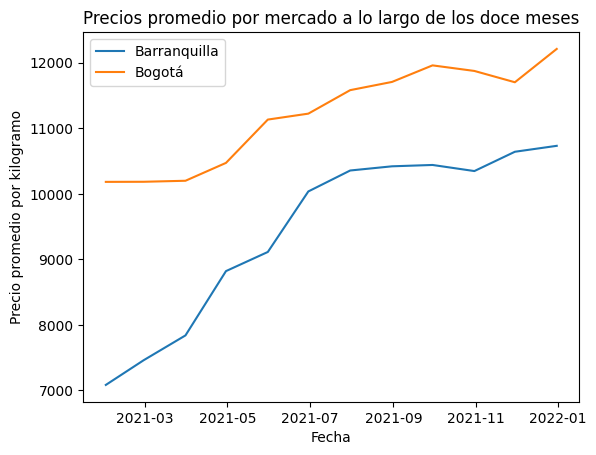

In [32]:
#grafico de precios promedio a lo largo de los doce meses
import matplotlib.pyplot as plt
promedios=df_filtrado.groupby(['Mercado', pd.Grouper(key='Fecha', freq='M')])['Precio promedio por kilogramo*'].mean()
df_promedios=promedios.to_frame().reset_index().pivot(index='Fecha', columns='Mercado',values='Precio promedio por kilogramo*')

plt.plot(df_promedios.index, df_promedios['Barranquilla, Barranquillita'], label='Barranquilla')
plt.plot(df_promedios.index, df_promedios['Bogotá, D.C., Corabastos'], label='Bogotá')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Precio promedio por kilogramo')
plt.title('Precios promedio por mercado a lo largo de los doce meses')
plt.show()